In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import os 
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import adaptive_avg_pool2d
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as dataset
import torchvision.utils as vutils

from PIL import Image
from scipy.linalg import sqrtm

from gan_main import Generator
from ClassifierNetwork import ResNet18, ResBlock, NetTrain, NetTest
from Utils import plot_metrics, make_classification_report, plot_confusion_matrix

In [ ]:
SEED=999
random.seed(SEED)
torch.manual_seed(SEED)

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# GPU
ngpu = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)
netG.apply(weights_init)
print(netG)
print("Generator Parameters:", sum(p.numel() for p in netG.parameters() if p.requires_grad))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
import torchvision.datasets as dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
image_size = 64
batch_size = 128

transform = transforms.Compose([transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)])

dataset = dataset.CIFAR10(root='./data', train=True, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:01<00:00, 105084039.25it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
import numpy as np
import random 
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as dataset
from torchvision.utils import save_image
from torchvision import transforms

ngpu = 1
nz = 100

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Define Handler Class to create GAN Dataset

class GAN_Dataset(torchvision.datasets.CIFAR10):

    def __init__(self, root, train = True, transform = None, 
                 target_transform = None, download = False):
        super().__init__(root, train = train, transform = transform,
                         target_transform = target_transform, 
                         download = download)

        if train:
            self.data, self.targets = self.create_imbalance(self.data,
                                                            self.targets)
            
            self.data, self.targets = self.generate_data(self.data,
                                                         self.targets)

    
    def create_imbalance(self, data, targets):

        """
        Remove 99% of the cat images from the dataset. Each category has
        5000 images. Therefore, remove 4950 cat images.
        """

        # Cat index is 3 in CIFAR - 10

        target_indices = [i for i, target in enumerate(targets) if target == 3] 
        target_indices = random.sample(target_indices, k = 4950)

        new_data = np.array([img for i, img in enumerate(data) if i not in target_indices])
        new_targets = [label for i, label in enumerate(targets) if i not in target_indices]

        return new_data, new_targets

    def generate_data(self, data, targets):

        """
        Use the remaining 50 cat images to create 4950 new cat images and add 
        them to the dataset.
        """

        new_data = []
        new_targets = []

        netG.load_state_dict(torch.load('/content/generator.pt'))
        netG.eval()

        num_images = 50

        # Generate and save images
        for i in range(num_images):
            # Generate random noise vector
            noise = torch.randn(1, nz, 1, 1).to(device)

            # Generate image using the generator
            with torch.no_grad():
                generated_image = netG(noise).detach().cpu().squeeze()
                generated_image = self.add_augmentation(generated_image)
            
            new_data.append(generated_image)
            new_targets.append(3)  # Cat index is 3

        new_data = np.array(new_data)

        return np.concatenate((data, new_data)), (targets + new_targets)

    
    def add_augmentation(self, data):

        """
        Create a new augmented image using the input image.
        """

        # Define the transformations to be applied

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((32, 32))
        ])

        # Apply the transformations to the image

        augmented_img = np.array(transform(data))
        
        return augmented_img

In [ ]:
train_transform = transforms.Compose([transforms.RandomCrop(32,
                                                            padding = 4),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean,
                                                            std)])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean,
                                                          std)])

trainset = GAN_Dataset(root = './data', train = True, 
                               transform = train_transform,
                               download = True)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = batch_size, 
                                          shuffle = True, 
                                          num_workers = 2, 
                                          worker_init_fn = np.random.seed(SEED))

testset = torchvision.datasets.CIFAR10(root = './data', train = False, 
                                       download = True, 
                                       transform = test_transform)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size = batch_size,
                                         shuffle = False, 
                                         num_workers = 2, 
                                         worker_init_fn = np.random.seed(SEED))

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Defining function to initialize the neural network

def init_network():

  criterion = nn.CrossEntropyLoss()

  net = ResNet18(3, ResBlock, outputs = 10)
  net.to(device) 

  optimizer = optim.SGD(net.parameters(), lr = 0.2, momentum = 0.0005, weight_decay = 5e-4)
    
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 10)

  return net, criterion, optimizer, scheduler 

# Initializing ResNet18 for GAN Generation

net, criterion, optimizer, scheduler = init_network()

In [ ]:
# Training the ResNet18 for GAN Generation

best_acc = 0
best_epoch = 0

train_accs = []
train_losses = []

test_accs = []
test_losses = []

for epoch in range(50):
  
  print(f'Epoch {epoch + 1} :')

  train_loss, train_acc = NetTrain(net, trainloader, device, optimizer, criterion)
  
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  print("Train Loss = " + str(train_loss) + "\t" + "Train Accuracy = " + str(train_acc))

  test_loss, test_acc, predictions, labels = NetTest(net, testloader, device, criterion)
  
  test_accs.append(test_acc)
  test_losses.append(test_loss)
  
  print("Test Loss = " + str(test_loss) + "\t" + "Test Accuracy = " +  str(test_acc))

  if test_acc > best_acc:
    best_acc = test_acc
    best_epoch = epoch

    torch.save(net.state_dict(), '/content/resnet_gan.pt')
  
  print("Best Test Accuracy = " + str(best_acc) + "\n")
  scheduler.step()

Epoch 1 :
Train Loss = 1.634767428335995	Train Accuracy = 39.73170731707317
Test Loss = 3.0459102045131634	Test Accuracy = 28.61
Best Test Accuracy = 28.61

Epoch 2 :
Train Loss = 1.0782927632669552	Train Accuracy = 61.529933481152995
Test Loss = 1.5854332809206806	Test Accuracy = 58.25
Best Test Accuracy = 58.25

Epoch 3 :
Train Loss = 0.7846751891857504	Train Accuracy = 72.58093126385809
Test Loss = 1.999318552922599	Test Accuracy = 49.92
Best Test Accuracy = 58.25

Epoch 4 :
Train Loss = 0.6141631862428303	Train Accuracy = 78.85809312638581
Test Loss = 1.6186568601221978	Test Accuracy = 59.18
Best Test Accuracy = 59.18

Epoch 5 :
Train Loss = 0.5114115295514844	Train Accuracy = 82.50776053215077
Test Loss = 1.176172297212142	Test Accuracy = 70.26
Best Test Accuracy = 70.26

Epoch 6 :
Train Loss = 0.42974670184908104	Train Accuracy = 85.31042128603104
Test Loss = 0.9676067459432385	Test Accuracy = 74.1
Best Test Accuracy = 74.1

Epoch 7 :
Train Loss = 0.3623107380890644	Train Accurac

In [ ]:
file_path = "/content/gan_dataset.npy"

np.save(file_path, trainset, allow_pickle=True, fix_imports=True)

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.asanyarray(arr)
/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


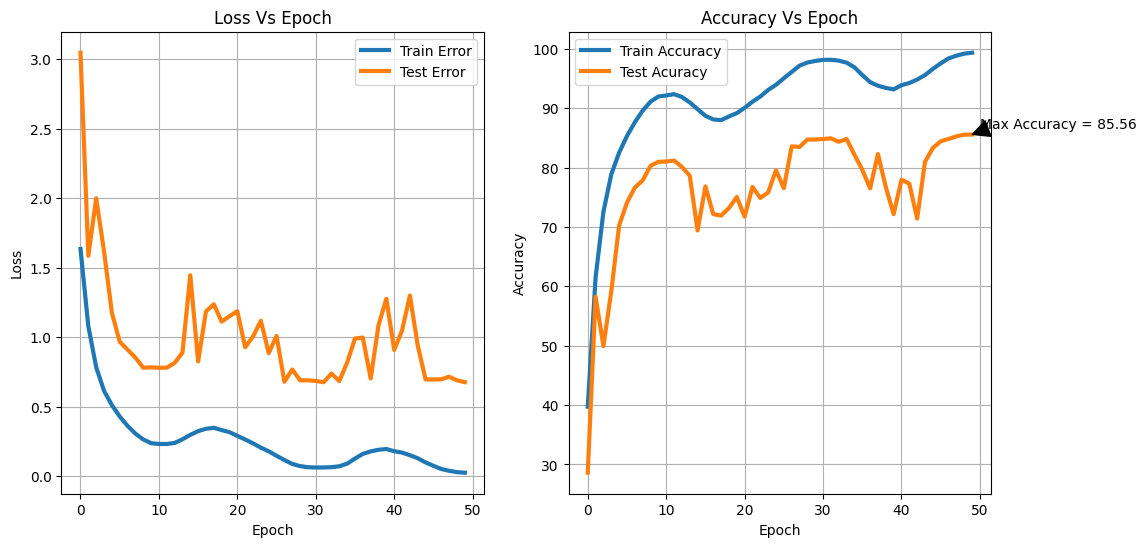

In [ ]:
plot_metrics(train_accs, test_accs, train_losses, test_losses, best_epoch, best_acc)

In [ ]:
# Making Classification Report 

net, criterion, optimizer, scheduler = init_network()

net.load_state_dict(torch.load('/content/resnet_gan.pt'))

test_loss , test_acc, predictions, labels = NetTest(net, testloader, device, criterion)

print(make_classification_report(labels, predictions, target_names = testset.classes))

              precision    recall  f1-score   support

    airplane       0.91      0.95      0.93      1000
  automobile       0.96      0.97      0.97      1000
        bird       0.83      0.91      0.87      1000
         cat       0.97      0.07      0.13      1000
        deer       0.86      0.93      0.89      1000
         dog       0.61      0.93      0.74      1000
        frog       0.85      0.95      0.90      1000
       horse       0.92      0.95      0.94      1000
        ship       0.94      0.95      0.94      1000
       truck       0.95      0.95      0.95      1000

    accuracy                           0.86     10000
   macro avg       0.88      0.86      0.82     10000
weighted avg       0.88      0.86      0.82     10000



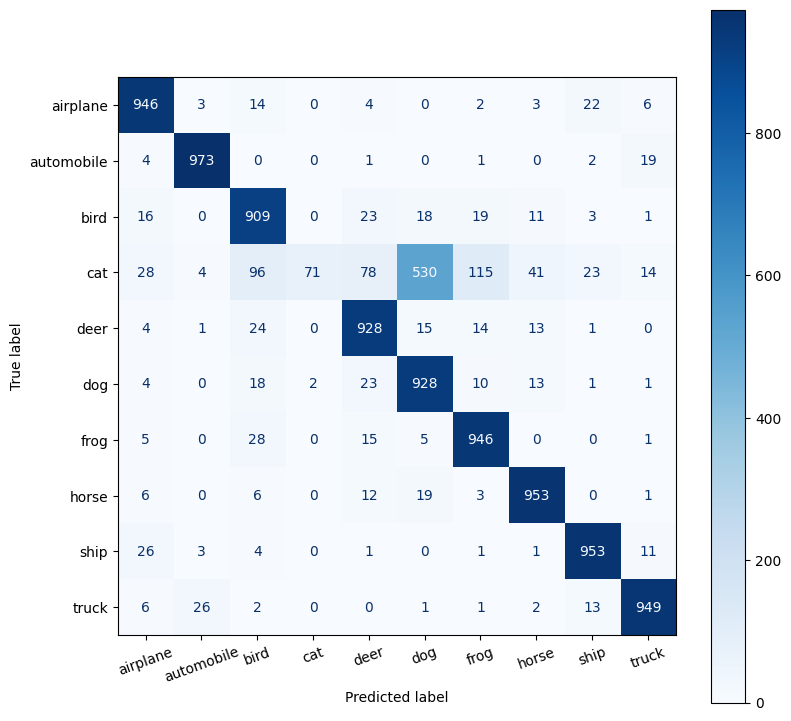

In [ ]:
# Plotting Confusion Matrix

plot_confusion_matrix(labels, predictions, testset.classes)